In [31]:
import pandas as pd
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import pandas_datareader.data as pdr
import numpy as np
from xgboost import plot_importance, plot_tree
from numpy import asarray
from math import sqrt
from matplotlib import pyplot
from datetime import date
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

import warnings
import matplotlib.pyplot as plt
import matplotlib
import plotly.graph_objects as go
import chart_studio.plotly as py
import plotly.offline as pyo
import plotly.io as pio
pio.renderers.default = 'notebook_connected'
import matplotlib as mpl    
import matplotlib.font_manager as fm
plt.rcParams['font.family']='NanumGothic'
print(plt.rcParams['font.family'])

warnings.filterwarnings(action='ignore')

['NanumGothic']


# 데이터 불러오기

In [125]:
## 데이터 불러오기
train = pd.read_csv("data/train.csv", encoding = 'euc-kr')
train['DateTime'] = pd.to_datetime(train['DateTime'])
train['date'] = train.DateTime.dt.date

new_train= pd.read_csv("data/2차_train.csv", encoding = 'euc-kr')
new_train['DateTime'] = pd.to_datetime(new_train['DateTime'])
new_train['date'] = new_train.DateTime.dt.date

## 시간 합산
train = pd.DataFrame(train.groupby('date').sum().reset_index())
new_train = pd.DataFrame(new_train.groupby('date').sum().reset_index())

## 1차 train과 2차 train 합치기
train = pd.concat([train, new_train]).reset_index(drop = True)
train_model = train.copy()
train.tail()

## submission 데이터
submission = pd.read_csv('data/submission.csv', encoding = 'euc-kr')
submission.DateTime = pd.to_datetime(submission.DateTime).dt.date
submission = submission[submission.DateTime>date(2020,12,8)].reset_index(drop = True)

# 추가 데이터 처리

In [126]:
login_info = pd.read_csv('data/new_login_info.csv', index_col=0)
competition_info = pd.read_csv('data/new_competition_info.csv', index_col=0, encoding='cp949')
user_info = pd.read_csv('data/new_user_info.csv', index_col=0)
submission_info = pd.read_csv('data/new_submission_info.csv', index_col=0).dropna(how = 'all')

In [127]:
# active_made

## id와 c_time만 남김
made_info = user_info[['id','c_time']]

## c_time과 id 모두 같은 곳에서 결측치기에 모두 삭제
made_info_dropna = made_info.dropna().copy()
made_info_dropna['c_time'] = pd.to_datetime(made_info_dropna['c_time'])

# 연월일로 나타내기
made_info_dropna['day'] = made_info_dropna['c_time'].apply(lambda x : x.strftime('%Y-%m-%d') )
made_info_dropna.day = pd.to_datetime(made_info_dropna.day).dt.date
made_info_dropna = made_info_dropna[made_info_dropna.day>=date(2018,9,9)].reset_index(drop = True)

# 아이디 생성한 사용자
active_made = made_info_dropna.groupby(['day'])['id'].nunique().reset_index()
active_made.day = pd.to_datetime(active_made.day).dt.date
active_made.rename(columns = {'id':'active_made'}, inplace = True)
active_made.tail(2)

# active login user & all login user

### active_login_user
## user_id와 c_time 변수를 제외한 나머지 모든 변수 제거
## 중간중간 있는 login_id나 user_id의 결측치도 모두 제거
login_info_drop_na = login_info[['user_id','c_time']].dropna().copy()
login_info_drop_na['c_time'] = pd.to_datetime(login_info_drop_na['c_time'])
## 연월일로 나타내기
login_info_drop_na['day'] = login_info_drop_na['c_time'].apply(lambda x : x.strftime('%Y-%m-%d') )
## 실제 로그인한 사용자가 몇 명인가
active_login_user = login_info_drop_na.groupby(['day'])['user_id'].nunique().reset_index()
active_login_user['day'] = pd.to_datetime(active_login_user['day']).dt.date
active_login_user.rename(columns = {'user_id':'active_login_user'}, inplace = True)
active_login_user



### all_login_user
## platform과 browser의 결측치가 많아 변수 제거 -> 유의미한 변수도 아님
## 중간중간 있는 login_id나 user_id의 결측치도 모두 제거
login_info_drop_na2 = login_info[['user_id','c_time']].copy()
## 총 사용자를 확인 하기 위해 결측치 다 채우기
login_info_drop_na2['user_id'].fillna(0, inplace = True)
login_info_drop_na2 = login_info_drop_na2.dropna()
login_info_drop_na2['c_time'] = pd.to_datetime(login_info_drop_na2['c_time'])
## 연월일로 나타내기
login_info_drop_na2['day'] = login_info_drop_na2['c_time'].apply(lambda x : x.strftime('%Y-%m-%d') )
## 해당 일에 로그인 횟수가 총 몇 번인가
all_login_user = login_info_drop_na2.groupby(['day'])['user_id'].count().reset_index()
all_login_user['day'] = pd.to_datetime(all_login_user['day']).dt.date
all_login_user.rename(columns = {'user_id':'all_login_user'}, inplace = True)
all_login_user.tail(2)

# 제출 정보 추가 데이터 확인

### team_id별 user_id별 제출 수 뽑기
sub_info = submission_info.copy()

sub_info_dropna = sub_info[['team_id','user_id','c_time']].dropna().copy()
sub_info_dropna.c_time = pd.to_datetime(sub_info_dropna.c_time)
# 연월로 나타내기
sub_info_dropna['day'] = sub_info_dropna['c_time'].apply(lambda x : x.strftime('%Y-%m-%d') )
sub_info_dropna = sub_info_dropna[(sub_info_dropna['day']>='2018-09-09')]


## 실제 제출한 사용자가 몇 명인가 : user_id
active_sub_user = sub_info_dropna.groupby(['day'])['user_id'].nunique().reset_index()
active_sub_user.day = pd.to_datetime(active_sub_user.day).dt.date
active_sub_user.rename(columns = {'user_id':'active_sub_user'}, inplace = True)
active_sub_user


## 팀 아이디로 정리 : 
active_sub_team = sub_info_dropna.groupby(['day'])['team_id'].nunique().reset_index()
active_sub_team.day = pd.to_datetime(active_sub_team.day).dt.date
active_sub_team.rename(columns = {'team_id':'active_sub_team'}, inplace = True)
active_sub_team.tail(2)

### team_id별 user_id별 제출 수 뽑기
sub_info = submission_info.copy()

sub_info_all = sub_info[['team_id','user_id','c_time']].copy()
sub_info_all.c_time = pd.to_datetime(sub_info_all.c_time)
sub_info_all[['team_id','user_id']] = sub_info_all[['team_id','user_id']].fillna(0)


# 연월로 나타내기
sub_info_all['day'] = sub_info_all['c_time'].apply(lambda x : x.strftime('%Y-%m-%d') )
sub_info_all = sub_info_all[(sub_info_all['day']>='2018-09-09')]

## 제출한 총 수
all_sub_user = sub_info_all.groupby(['day'])['user_id'].count().reset_index()
all_sub_user.day = pd.to_datetime(all_sub_user.day).dt.date
all_sub_user.rename(columns = {'user_id':'all_sub_user'}, inplace = True)

## 팀 아이디로 제출한 총 수
all_sub_team = sub_info_all.groupby(['day'])['team_id'].count().reset_index()
all_sub_team.day = pd.to_datetime(all_sub_team.day).dt.date
all_sub_team.rename(columns = {'team_id':'all_sub_team'}, inplace = True)
all_sub_team.tail(2)


# 공통된 요일 기준 병합

### 제출수 요일이 가장 적으므로 '제출'을 기준으로 병합
print(active_made.shape)
print(active_login_user.shape)
print(all_login_user.shape)
print(active_sub_user.shape)
print(active_sub_team.shape)
print(all_sub_user.shape)
print(all_sub_team.shape)

add_data_list = [all_login_user, active_sub_user, active_sub_team, all_sub_user, all_sub_team]
add_data = pd.merge(active_made, active_login_user, how = 'inner', on = 'day')
for i in add_data_list:
    add_data = pd.merge(add_data, i, how = 'inner', on = 'day')
    
add_data = add_data.rename(columns = {'day':'date'})
add_data.tail()

(842, 2)
(839, 2)
(839, 2)
(779, 2)
(779, 2)
(779, 2)
(779, 2)


,date,active_made,active_login_user,all_login_user,active_sub_user,active_sub_team,all_sub_user,all_sub_team
752,2021-01-04,117,387,477,129,118,283,283
753,2021-01-05,101,365,453,131,120,268,268
754,2021-01-06,100,555,639,197,178,430,430
755,2021-01-07,81,420,480,197,174,412,412
756,2021-01-08,82,358,449,205,178,408,408


# 전체적인 부분
- (2,2) 행렬로 표현

In [128]:
## 시용자
plot_data = [
    go.Scatter(
        x=train['date'],
        y=train['사용자']
    )
]
plot_layout = go.Layout(
    xaxis = {
        'type': 'category',
        'title' : 'date'
    },
    yaxis = {
        'title' : 'User'
    },
    title = 'train User',
)
fig = go.Figure(data=plot_data, layout = plot_layout)
pyo.iplot(fig)


## 세션
plot_data = [
    go.Scatter(
        x=train['date'],
        y=train['세션']
    )
]
plot_layout = go.Layout(
    xaxis = {
        'type': 'category',
        'title' : 'date'
    },
    yaxis = {
        'title' : 'Sess'
    },
    title = 'train Sess',
)
fig = go.Figure(data=plot_data, layout = plot_layout)
pyo.iplot(fig)


## 신규방문자
plot_data = [
    go.Scatter(
        x=train['date'],
        y=train['신규방문자']
    )
]
plot_layout = go.Layout(
    xaxis = {
        'type': 'category',
        'title' : 'date'
    },
    yaxis = {
        'title' : 'New'
    },
    title = 'train New',
)
fig = go.Figure(data=plot_data, layout = plot_layout)
pyo.iplot(fig)


## 페이지뷰
plot_data = [
    go.Scatter(
        x=train['date'],
        y=train['페이지뷰']
    )
]
plot_layout = go.Layout(
    xaxis = {
        'type': 'category',
        'title' : 'date'
    },
    yaxis = {
        'title' : 'Page'
    },
    title = 'train Page',
)
fig = go.Figure(data=plot_data, layout = plot_layout)
pyo.iplot(fig)

# 연도별 시각화
- (1,4) 행렬로 표현

In [129]:
### 연도별 Y의 평균
## 연도만 뽑기
train['year'] = train['date'].apply(lambda x : x.strftime('%Y'))

year_train = train.groupby(['year'])[['사용자','세션','신규방문자','페이지뷰']].mean().reset_index()
year_train.head()

,year,사용자,세션,신규방문자,페이지뷰
0,2018,206.947368,204.780702,63.000000,1618.482456
1,2019,506.819178,524.487671,159.430137,6284.134247
2,2020,2216.682216,2172.446064,498.209913,55868.854227


In [130]:
## 사용자
plot_data = [
    go.Scatter(
        x=year_train['year'],
        y=year_train['사용자']
    )
]
plot_layout = go.Layout(
    xaxis = {
        'type': 'category',
        'title' : 'date'
    },
    yaxis = {
        'title' : 'User'
    },
    title = 'train User',
)
fig = go.Figure(data=plot_data, layout = plot_layout)
pyo.iplot(fig)


## 세션
plot_data = [
    go.Scatter(
        x=year_train['year'],
        y=year_train['세션']
    )
]
plot_layout = go.Layout(
    xaxis = {
        'type': 'category',
        'title' : 'date'
    },
    yaxis = {
        'title' : 'Sess'
    },
    title = 'train Sess',
)
fig = go.Figure(data=plot_data, layout = plot_layout)
pyo.iplot(fig)


## 신규방문자
plot_data = [
    go.Scatter(
        x=year_train['year'],
        y=year_train['신규방문자']
    )
]
plot_layout = go.Layout(
    xaxis = {
        'type': 'category',
        'title' : 'date'
    },
    yaxis = {
        'title' : 'New'
    },
    title = 'train New',
)
fig = go.Figure(data=plot_data, layout = plot_layout)
pyo.iplot(fig)


## 페이지뷰
plot_data = [
    go.Scatter(
        x=year_train['year'],
        y=year_train['페이지뷰']
    )
]
plot_layout = go.Layout(
    xaxis = {
        'type': 'category',
        'title' : 'date'
    },
    yaxis = {
        'title' : 'Page'
    },
    title = 'train Page',
)
fig = go.Figure(data=plot_data, layout = plot_layout)
pyo.iplot(fig)

# 월별 시각화

In [131]:
### 연도별 Y의 평균
## 연도만 뽑기
train['month'] = train['date'].apply(lambda x : x.strftime('%Y-%m'))

year_train = train.groupby(['month'])[['사용자','세션','신규방문자','페이지뷰']].mean().reset_index()
year_train.head()

,month,사용자,세션,신규방문자,페이지뷰
0,2018-09,226.409091,213.409091,47.227273,1615.590909
1,2018-10,149.129032,148.774194,53.064516,909.645161
2,2018-11,222.233333,226.066667,84.033333,1704.900000
3,2018-12,236.161290,234.064516,63.774194,2245.741935
4,2019-01,302.387097,300.870968,84.032258,2434.612903


In [132]:
## 사용자
plot_data = [
    go.Scatter(
        x=year_train['month'],
        y=year_train['사용자']
    )
]
plot_layout = go.Layout(
    xaxis = {
        'type': 'category',
        'title' : 'date'
    },
    yaxis = {
        'title' : 'User'
    },
    title = 'train User',
)
fig = go.Figure(data=plot_data, layout = plot_layout)
pyo.iplot(fig)


## 세션
plot_data = [
    go.Scatter(
        x=year_train['month'],
        y=year_train['세션']
    )
]
plot_layout = go.Layout(
    xaxis = {
        'type': 'category',
        'title' : 'date'
    },
    yaxis = {
        'title' : 'Sess'
    },
    title = 'train Sess',
)
fig = go.Figure(data=plot_data, layout = plot_layout)
pyo.iplot(fig)


## 신규방문자
plot_data = [
    go.Scatter(
        x=year_train['month'],
        y=year_train['신규방문자']
    )
]
plot_layout = go.Layout(
    xaxis = {
        'type': 'category',
        'title' : 'date'
    },
    yaxis = {
        'title' : 'New'
    },
    title = 'train New',
)
fig = go.Figure(data=plot_data, layout = plot_layout)
pyo.iplot(fig)


## 페이지뷰
plot_data = [
    go.Scatter(
        x=year_train['month'],
        y=year_train['페이지뷰']
    )
]
plot_layout = go.Layout(
    xaxis = {
        'type': 'category',
        'title' : 'date'
    },
    yaxis = {
        'title' : 'Page'
    },
    title = 'train Page',
)
fig = go.Figure(data=plot_data, layout = plot_layout)
pyo.iplot(fig)

# 월의 특징 파악
- 19년 12월부터 20년의 11월까지 특징 그래프 그리기
- 12개를 4행 3열로 나타내서 그리기 -> 그래프 잘 보이도록 편하게 조정
- 12월 31일, 1월 1일이 떨어진다는 점 보이기 위함
- 최근의 특징을 가장 많이 가지고 있는 2020년의 데이터에서 월별로 그래프를 그려보았을 때 주말 및 휴일에는 하락하고 평일에는 상승하는 점이 보임
- 특징있는 날을 제외하고서는 한달 이내 상승점들의 높이는 비슷하고 하락점 또한 마찬가지
- 공휴일과 주말이 비슷한 모습을 보임

In [133]:
# train['date'] = pd.to_datetime(train['date'])


train['dayofmonth'] = pd.to_datetime(train['date']).dt.day
train['month'] = pd.to_datetime(train['date']).dt.month
train['year'] = pd.to_datetime(train['date']).dt.year

#### 사용자
#### 가장 최근 월별로 Y 분석을 해본 뒤에 월초와 월말을 어떤식으로 나눌지에 대해서 고민
# 1,2,3,4,5월 분석
train_1 = train[(train['month']==1) & (train['year']==2020)]
train_2 = train[(train['month']==2) & (train['year']==2020)]
train_3 = train[(train['month']==3) & (train['year']==2020)]
train_4 = train[(train['month']==4) & (train['year']==2020)]
train_5 = train[(train['month']==5) & (train['year']==2020)]
train_6 = train[(train['month']==6) & (train['year']==2020)]

# 6,7,8,9,10월 분석
train_6 = train[(train['month']==6) & (train['year']==2020)]
train_7 = train[(train['month']==7) & (train['year']==2020)]
train_8 = train[(train['month']==8) & (train['year']==2020)]
train_9 = train[(train['month']==9) & (train['year']==2020)]
train_10 = train[(train['month']==10) & (train['year']==2020)]
train_11 = train[(train['month']==11) & (train['year']==2020)]


# 19년 5~12월 진행
train_4_19 = train[(train['month']==4) & (train['year']==2019)]
train_5_19 = train[(train['month']==5) & (train['year']==2019)]
train_6_19 = train[(train['month']==6) & (train['year']==2019)]
train_7_19 = train[(train['month']==7) & (train['year']==2019)]
train_8_19 = train[(train['month']==8) & (train['year']==2019)]
train_9_19 = train[(train['month']==9) & (train['year']==2019)]
train_10_19 = train[(train['month']==10) & (train['year']==2019)]
train_11_19 = train[(train['month']==11) & (train['year']==2019)]
train_12_19 = train[(train['month']==12) & (train['year']==2019)]

# 18년 10월 11월 12월 19년 1월 2월 4월
train_10_18 = train[(train['month']==10) & (train['year']==2018)]
train_11_18 = train[(train['month']==11) & (train['year']==2018)]
train_12_18 = train[(train['month']==12) & (train['year']==2018)]
train_1_19 = train[(train['month']==1) & (train['year']==2019)]
train_2_19 = train[(train['month']==2) & (train['year']==2019)]




train_early_8 = train[(train['dayofmonth'] < 10) & (train['month']==8)]
train_later_8 = train[(train['dayofmonth'] > 20) & (train['month']==8)]

train_early_9 = train[(train['dayofmonth'] < 10) & (train['month']==9)]
train_later_9 = train[(train['dayofmonth'] > 20) & (train['month']==9)]

train_early_10 = train[(train['dayofmonth'] < 10) & (train['month']==10)]
train_later_10 = train[(train['dayofmonth'] > 20) & (train['month']==10)]

# 연휴 기간 추가
- 연휴 기간에도 휴일과 같이 하락한 모습을 보임
- 20년 5월의 연휴 확인
- 19년 12월 31일 연말 모습 확인
- 18년 12/31, 19년 12/31, 추가 데이터의 제출 수, 로그인 수, 아이디 생성 수 등을 시각화로 보이기

In [134]:
## 18년과 19년 12/31 ~ 1/1
train_later_18 = train[(train['date']>=date(2018, 12, 23))&(train['date']<=date(2019, 1, 5))]
train_later_19 = train[(train['date']>=date(2019, 12, 23))&(train['date']<=date(2020, 1, 5))]

## 추가데이터 12/31 ~ 1/1
add_later18 = add_data[(add_data['date']>=date(2018, 12, 20))&(add_data['date']<=date(2019, 1, 5))]
add_later19 = add_data[(add_data['date']>=date(2019, 12, 20))&(add_data['date']<=date(2020, 1, 5))]

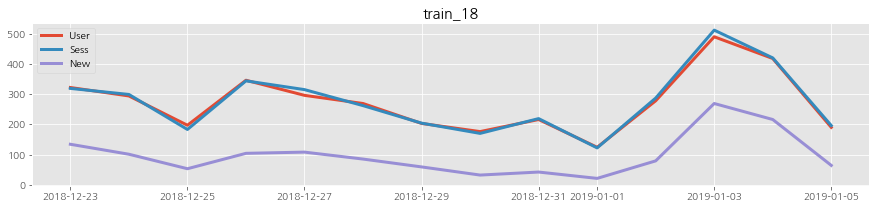

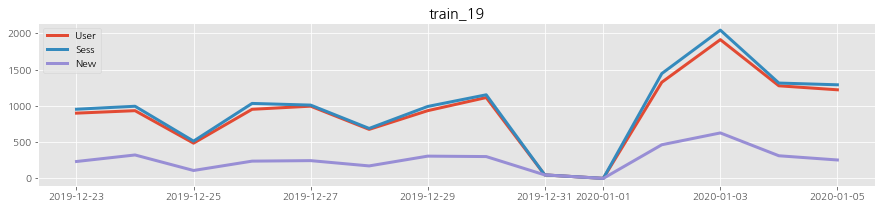

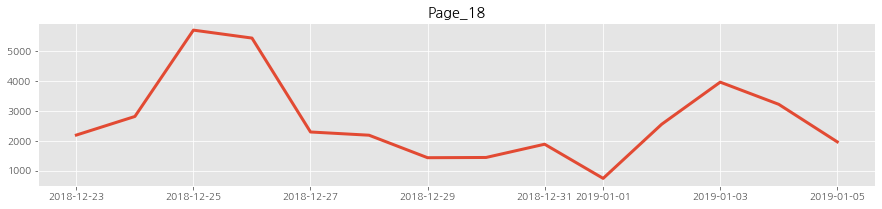

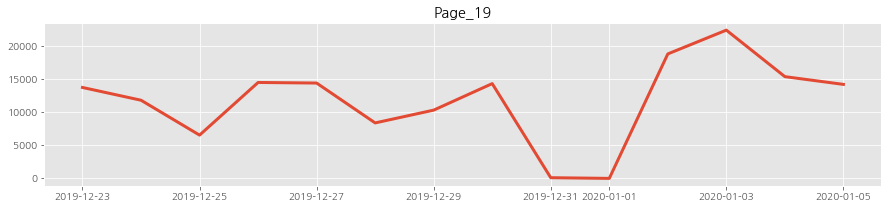

In [223]:
## train 데이터의 연말 연초(사용자, 세션, 신규방문자)
plt.figure(figsize = (15,3))
plt.plot(train_later_18.date, train_later_18.사용자, linewidth=3, label = 'User')
plt.plot(train_later_18.date, train_later_18.세션, linewidth=3, label = 'Sess')
plt.plot(train_later_18.date, train_later_18.신규방문자, linewidth=3, label = 'New')
plt.legend(loc='upper left')
plt.title('train_18')
plt.show()

plt.figure(figsize = (15,3))
plt.plot(train_later_19.date, train_later_19.사용자, linewidth=3, label = 'User')
plt.plot(train_later_19.date, train_later_19.세션, linewidth=3, label = 'Sess')
plt.plot(train_later_19.date, train_later_19.신규방문자, linewidth=3, label = 'New')
plt.legend(loc='upper left')
plt.title('train_19')
plt.show()

## train 연말 연초 (페이지뷰)
plt.figure(figsize = (15,3))
plt.plot(train_later_18.date, train_later_18.페이지뷰, linewidth=3, label = 'Page_18')
plt.title('Page_18')
plt.show()
plt.figure(figsize = (15,3))
plt.plot(train_later_19.date, train_later_19.페이지뷰, linewidth=3, label = 'Page_19')
plt.title('Page_19')
plt.show()

- 신규 아이디 생성자(active_made)와 실제 팀, 사용자 제출 수는 18년 연말 모두 하락세
- 전체적으로 수치가 낮으나 크리스마스와 1월 1일이 가장 낮은 것을 알 수 있음.
- 평일에 비해 크리스마스, 주말, 12월 31일은 모두 낮은 모습을 보임

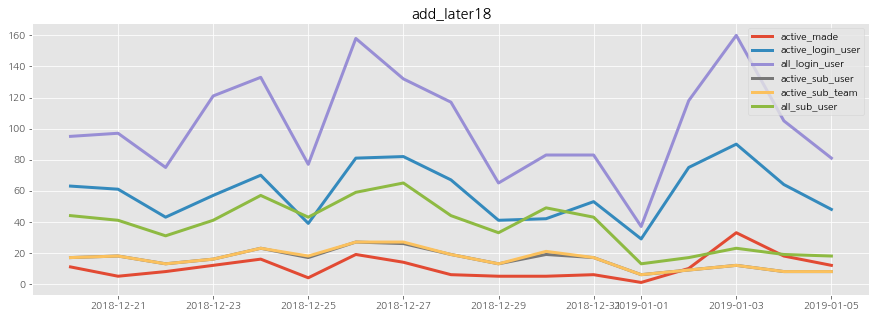

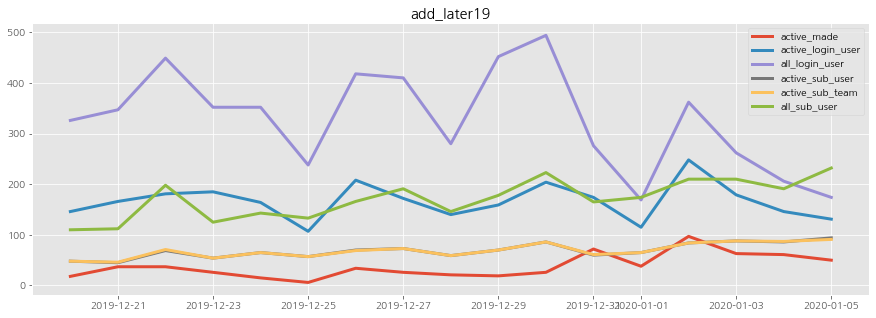

In [136]:
## train 데이터의 연말 연초(사용자, 세션, 신규방문자)
plt.figure(figsize = (15,5))
plt.plot(add_later18.date, add_later18.active_made, linewidth=3, label = 'active_made')
plt.plot(add_later18.date, add_later18.active_login_user, linewidth=3, label = 'active_login_user')
plt.plot(add_later18.date, add_later18.all_login_user, linewidth=3, label = 'all_login_user')
plt.plot(add_later18.date, add_later18.active_sub_user, linewidth=3, label = 'active_sub_user')
plt.plot(add_later18.date, add_later18.active_sub_team, linewidth=3, label = 'active_sub_team')
plt.plot(add_later18.date, add_later18.all_sub_user, linewidth=3, label = 'all_sub_user')
plt.legend(loc='upper right')
plt.title('add_later18')
plt.show()

## train 데이터의 연말 연초(사용자, 세션, 신규방문자)
plt.figure(figsize = (15,5))
plt.plot(add_later19.date, add_later19.active_made, linewidth=3, label = 'active_made')
plt.plot(add_later19.date, add_later19.active_login_user, linewidth=3, label = 'active_login_user')
plt.plot(add_later19.date, add_later19.all_login_user, linewidth=3, label = 'all_login_user')
plt.plot(add_later19.date, add_later19.active_sub_user, linewidth=3, label = 'active_sub_user')
plt.plot(add_later19.date, add_later19.active_sub_team, linewidth=3, label = 'active_sub_team')
plt.plot(add_later19.date, add_later19.all_sub_user, linewidth=3, label = 'all_sub_user')
plt.legend(loc='upper right')
plt.title('add_later19')
plt.show()

------------

- Y 모두 20년의 경우 석가탄신일을 기점으로 하락하면서 연휴 기간 내내 하락세
- 로그인 수, 제출 수 등 연휴 기간 동안 하락세
- 공휴일 휴일이 아니더라도 긴 연휴에 포함되는 날은 공휴일 및 주말과 같은 패턴을 보임

In [137]:
## 19년과 20년 5월 연휴
train_5_19 = train[(train['date']>=date(2019, 4, 25))&(train['date']<=date(2019, 5, 10))]
train_5_20 = train[(train['date']>=date(2020, 4, 25))&(train['date']<=date(2020, 5, 10))]

## 추가데이터 5월 연휴
add_5_18 = add_data[(add_data['date']>=date(2019, 4, 25))&(add_data['date']<=date(2019, 5, 10))]
add_5_19 = add_data[(add_data['date']>=date(2020, 4, 25))&(add_data['date']<=date(2020, 5, 10))]

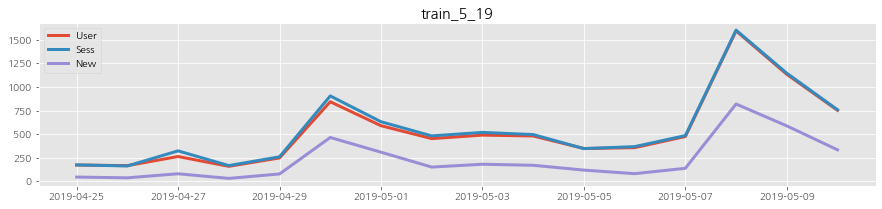

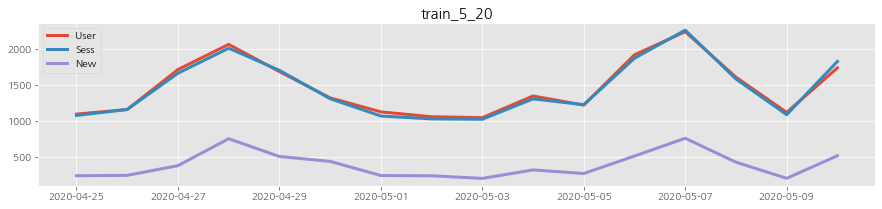

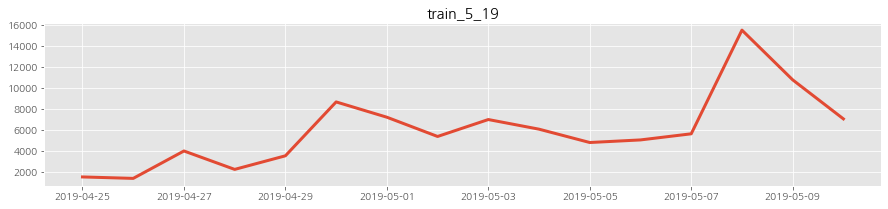

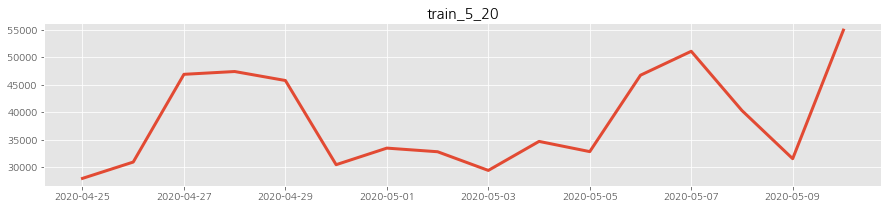

In [222]:
## train 데이터의 연말 연초(사용자, 세션, 신규방문자)
plt.figure(figsize = (15,3))
plt.plot(train_5_19.date, train_5_19.사용자, linewidth=3, label = 'User')
plt.plot(train_5_19.date, train_5_19.세션, linewidth=3, label = 'Sess')
plt.plot(train_5_19.date, train_5_19.신규방문자, linewidth=3, label = 'New')
plt.legend(loc='upper left')
plt.title('train_5_19')
plt.show()

plt.figure(figsize = (15,3))
plt.plot(train_5_20.date, train_5_20.사용자, linewidth=3, label = 'User')
plt.plot(train_5_20.date, train_5_20.세션, linewidth=3, label = 'Sess')
plt.plot(train_5_20.date, train_5_20.신규방문자, linewidth=3, label = 'New')
plt.legend(loc='upper left')
plt.title('train_5_20')
plt.show()

## train 연말 연초 (페이지뷰)
plt.figure(figsize = (15,3))
plt.plot(train_5_19.date, train_5_19.페이지뷰, linewidth=3, label = 'Page_18')
plt.title('train_5_19')
plt.show()
plt.figure(figsize = (15,3))
plt.plot(train_5_20.date, train_5_20.페이지뷰, linewidth=3, label = 'Page_19')
plt.title('train_5_20')
plt.show()

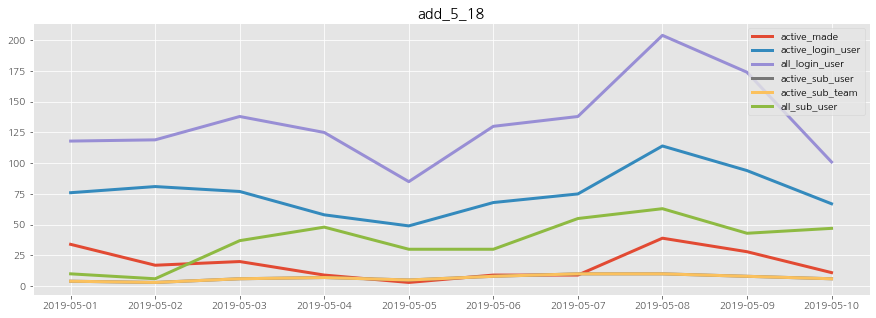

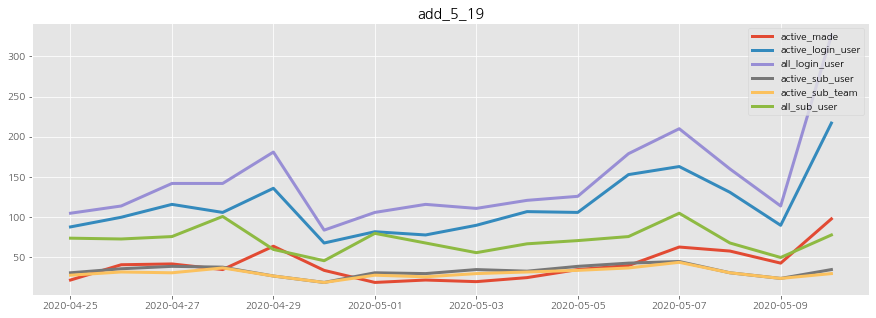

In [139]:
## train 데이터의 연말 연초(사용자, 세션, 신규방문자)
plt.figure(figsize = (15,5))
plt.plot(add_5_18.date, add_5_18.active_made, linewidth=3, label = 'active_made')
plt.plot(add_5_18.date, add_5_18.active_login_user, linewidth=3, label = 'active_login_user')
plt.plot(add_5_18.date, add_5_18.all_login_user, linewidth=3, label = 'all_login_user')
plt.plot(add_5_18.date, add_5_18.active_sub_user, linewidth=3, label = 'active_sub_user')
plt.plot(add_5_18.date, add_5_18.active_sub_team, linewidth=3, label = 'active_sub_team')
plt.plot(add_5_18.date, add_5_18.all_sub_user, linewidth=3, label = 'all_sub_user')
plt.legend(loc='upper right')
plt.title('add_5_18')
plt.show()

## train 데이터의 연말 연초(사용자, 세션, 신규방문자)
plt.figure(figsize = (15,5))
plt.plot(add_5_19.date, add_5_19.active_made, linewidth=3, label = 'active_made')
plt.plot(add_5_19.date, add_5_19.active_login_user, linewidth=3, label = 'active_login_user')
plt.plot(add_5_19.date, add_5_19.all_login_user, linewidth=3, label = 'all_login_user')
plt.plot(add_5_19.date, add_5_19.active_sub_user, linewidth=3, label = 'active_sub_user')
plt.plot(add_5_19.date, add_5_19.active_sub_team, linewidth=3, label = 'active_sub_team')
plt.plot(add_5_19.date, add_5_19.all_sub_user, linewidth=3, label = 'all_sub_user')
plt.legend(loc='upper right')
plt.title('add_5_19')
plt.show()

# 대회 개수의 영향력 확인
- 일별 진행중인 대회 개수가 다르고 그에 따른 참가자 수 또한 다르다.
- 진행중인 대회 수에 따른 Y의 분포 차이 확인
- 진행되는 대회 수가 많을 수록 Y가 모두 커짐

In [140]:
competition_info.isnull().sum()

cpt_id               1
is_official          1
period_start         1
period_end           1
sponsor             52
name                 1
name_eng            27
keyword              2
keyword_eng         28
participants         1
max_team_member      1
max_file_per_day     1
prize                1
prize_info          19
merge_deadline       1
winner_show          1
dtype: int64

In [141]:
## 필요한 변수만 남긴 뒤 결측치와 변수 제거
competition = competition_info[['period_start','period_end']].dropna()

# competition

# 각 날짜별 진행되고 있는 대회 개수
# competition 데이터셋의 모든 기간을 포함.

def date_cpt_count(competition):
    from datetime import date, timedelta

    # datatype: datetime으로 변경
    competition['period_start'] =  pd.to_datetime(competition.period_start)
    competition['period_end'] =  pd.to_datetime(competition.period_end)
    # date로 변경
    competition['period_start'] = competition.period_start.dt.date
    competition['period_end'] = competition.period_end.dt.date

    # 모든 대회 기간을 포함하는 datelist 생성. 897개
    start = competition['period_start'].min()
    end = competition['period_end'].max()

    datelist = []
    for i in range((end-start).days +1):
        datelist.append(start+timedelta(days=i))

    # 각 날짜에 대회가 몇개 열렸는지 매칭.
    cpt_cnt = [0 for i in range(len(datelist))] 

    for i in range(len(competition)):
        s = competition.iloc[i]['period_start']
        e = competition.iloc[i]['period_end']
      
        t = 0
        for d in datelist:
            if d >= s and d<=e:
                cpt_cnt[t]+=1
            t+=1

    date_cpt_cnt = pd.DataFrame({'date':datelist
                                ,'count': cpt_cnt})
    date_cpt_cnt.head()

    return date_cpt_cnt

competition = date_cpt_count(competition)

## 대회 개수 변수  추가
train['competition_counts'] = pd.Series(competition[(competition['date']>=date(2018,9,9)) & (competition['date']<=date(2020, 12, 8))].reset_index(drop = True)['count'])
submission['competition_counts'] = pd.Series(competition[(competition['date']>=date(2020,12,9)) & (competition['date']<=date(2021, 1, 8))].reset_index(drop = True)['count'])

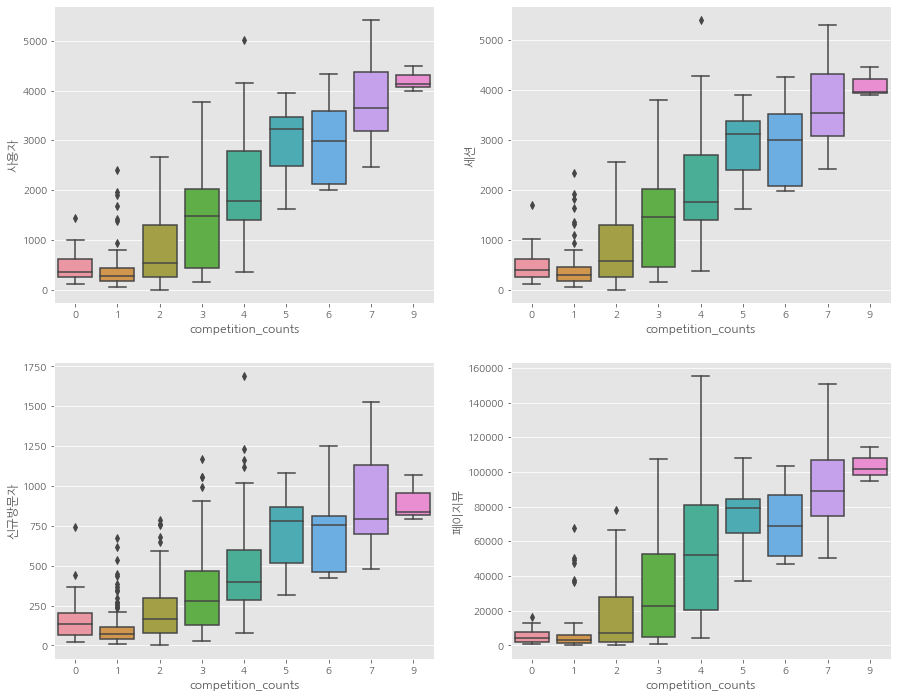

In [147]:
plt.figure(figsize = (15,12))
plt.subplot(2, 2, 1)
sns.boxplot(x = 'competition_counts',
           y = '사용자',
           data = train)
plt.subplot(2, 2, 2)
sns.boxplot(x = 'competition_counts',
           y = '세션',
           data = train)
plt.subplot(2, 2, 3)
sns.boxplot(x = 'competition_counts',
           y = '신규방문자',
           data = train)
plt.subplot(2, 2, 4)
sns.boxplot(x = 'competition_counts',
           y = '페이지뷰',
           data = train)

# Y별 가장 큰 값들이 존재하는 날의 특징 파악
- 휴일과 평일의 오르내림과 달리 유난히 높은 값을 갖는 날이 확인됨(7/31)
- 2020년부터 본격적인 상승세를 타는 모습에서 어떠한 패턴을 가지고 있지 않기에 해당 날만이 가진 특수성을 파악해야 한다고 생각
- 월간 데이콘과 같은 대회가 아닌 '코로나 대회'등과 같은 일정한 패턴이 없고 강한 특수성을 가진 대회의 정보는 반영하기 어렵다고 판단
- 추가 데이터를 통해 확인할 수 있는 '로그인 수','제출 수','아이디 생성 수','참가자 수','대회 마감일'등의 정보를 종합하여 확인

In [334]:
## 대회 시작일과 마감일 뽑기
top_competition = competition_info[['period_start','period_end','name','participants','merge_deadline']].dropna()
for i in ['period_start','period_end','merge_deadline']:
    top_competition[i] = pd.to_datetime(top_competition[i]).dt.date

top_user = list(train.sort_values(by = '사용자', ascending = False)['date'].head())
top_sess = list(train.sort_values(by = '세션', ascending = False)['date'].head())
top_new = list(train.sort_values(by = '신규방문자', ascending = False)['date'].head())
top_page = list(train.sort_values(by = '페이지뷰', ascending = False)['date'].head())

top_list = list(set(top_user)|set(top_sess)|set(top_new)|set(top_page))

df=[]
for i in ['period_end','merge_deadline']:
    print(top_competition[top_competition[i].isin(top_list)].groupby(i)['participants'].sum())

period_end
2020-07-31    3572.0
2020-11-16    1696.0
Name: participants, dtype: float64
merge_deadline
2020-11-02    1298.0
2020-11-25     682.0
Name: participants, dtype: float64


- 11월 25일을 제외하고 각 Y에서 높은 값을 갖는 날들은 팅 병합 마감하거나 끝나는 대회가 1000명 이상인 것으로 보인다.
- test기간 중 참가자가 1000명이 넘는 대회가 끝나거나 팀 병합이 마감하는지 확인
- 만약 존재한다면 위의 가정을 바탕으로 알고리즘의 정확도를 대략적으로 검증 가능
- test 기간 중에서는 1000명 이상의 대회가 끝나는 12월 31일과 1000명 이상이 참가하는 대회의 시작일인 1월 6일이 포함되어 있음

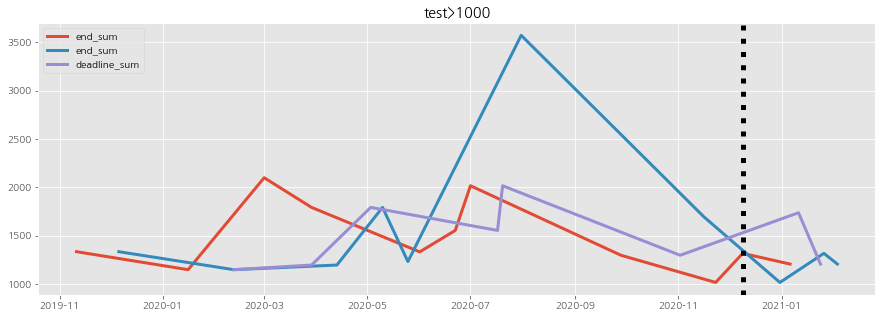

In [333]:
## test 기간 확인
start = top_competition[['period_start','participants']]
start_sum = start.groupby('period_start').sum().reset_index()
start_sum = start_sum[start_sum.participants>1000].reset_index(drop = True)

end = top_competition[['period_end','participants']]
end_sum = end.groupby('period_end').sum().reset_index()
end_sum = end_sum[end_sum.participants>1000].reset_index(drop = True)

deadline = top_competition[['merge_deadline','participants']]
deadline_sum = deadline.groupby('merge_deadline').sum().reset_index()
deadline_sum = deadline_sum[deadline_sum.participants>1000].reset_index(drop = True)

## train 데이터의 연말 연초(사용자, 세션, 신규방문자)
plt.figure(figsize = (15,5))
plt.plot(start_sum.period_start, start_sum.participants, linewidth=3, label = 'end_sum')
plt.plot(end_sum.period_end, end_sum.participants, linewidth=3, label = 'end_sum')
plt.plot(deadline_sum.merge_deadline, deadline_sum.participants, linewidth=3, label = 'deadline_sum')
plt.axvline(x=date(2020,12,9), color='black', linewidth=5, linestyle=':')
plt.legend(loc='upper left')
plt.title('test>1000')
plt.show()

# 공휴일 데이터 추가

In [ ]:
## 공휴일 데이터 생성
date="""2018-09-23, 2018-09-24, 2018-09-25, 2018-09-26, 2018-10-03, 2018-10-09, 2018-12-25, 2019-01-01, 2019-02-04, 2019-02-05, 2019-02-06, 2019-03-01, 2019-05-05, 2019-05-06, 2019-05-12, 2019-06-06, 2019-07-17, 2019-08-15, 2019-09-12, 2019-09-13, 2019-09-14, 2019-10-03, 2019-10-09, 2019-12-25, 2020-01-01, 2020-01-24, 2020-01-25, 2020-01-26, 2020-01-27, 2020-03-01, 2020-04-15, 2020-04-30, 2020-05-05, 2020-06-06, 2020-07-17, 2020-08-15, 2020-08-17, 2020-09-30, 2020-10-01, 2020-10-02, 2020-10-03, 2020-10-09, 2020-12-25, 2021-01-01"""
name="""추석, 추석, 추석, 대체휴무일, 개천절, 한글날, 기독탄신일, 1월1일, 설날, 설날, 설날, 삼일절, 어린이날, 대체공휴일, 부처님오신날, 현충일, 제헌절, 광복절, 추석, 추석, 추석, 개천절, 한글날, 기독탄신일, 1월1일, 설날, 설날, 설날, 설날, 삼일절, 제21대 국회의원선거, 부처님오신날, 어린이날, 현충일, 제헌절, 광복절, 임시공휴일, 추석, 추석, 추석, 개천절, 한글날, 기독탄신일, 1월1일"""

date=date.split(',')
name=name.split(',')
holidays=pd.DataFrame({'date':date,'name':name})
holidays.head()